In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Мы будем работать с данными агрегатора такси [Sigma Cabs](https://www.kaggle.com/datasets/arashnic/taxi-pricing-with-mobility-analytics). В зависимости от характеристик поездки требуется предсказать один из трех типов повышенного ценообразования: [1, 2, 3]. Таким образом, это поможет компании оптимально мэтчить такси и клиентов. 

In [109]:
df = pd.read_csv('sigma_cabs.csv')
df.shape

(131662, 14)

In [110]:
df['Surge_Pricing_Type'].value_counts()

Surge_Pricing_Type
2    56728
3    47720
1    27214
Name: count, dtype: int64

In [111]:
# Занесем индекс колонку
df = df.set_index('Trip_ID')
df.head()

,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
Trip_ID,,,,,,,,,,,,,
T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


Описание признаков:

1. **Trip_ID**: ID for TRIP
2. **Trip_Distance**: The distance for the trip requested by the customer
3. **TypeofCab**: Category of the cab requested by the customer
4. **CustomerSinceMonths**: Customer using cab services since n months; 0 month means current month
5. **LifeStyleIndex**: Proprietary index created by Sigma Cabs showing lifestyle of the customer based on their behaviour
6. **ConfidenceLifeStyle_Index**: Category showing confidence on the index mentioned above
7. **Destination_Type**: Sigma Cabs divides any destination in one of the 14 categories.
8. **Customer_Rating**: Average of life time ratings of the customer till date
9. **CancellationLast1Month**: Number of trips cancelled by the customer in last 1 month
10. **Var1**, **Var2** and **Var3**: Continuous variables masked by the company. Can be used for modelling purposes
11. **Gender**: Gender of the customer

**SurgePricingType**: Target (can be of 3 types)


### EDA 
Заполните пропуски в вещественных признаках медианой, а в категориальных - самым популярным классом. Изобразите марицу корреляций и выведите топ5 пар самых коррелированных признаков.

Так как в сумме уникальных значений различных категориальных признаков окажется не супер-много, примените `One-Hot-Encoding` для них. Не забудьте в методе `pd.get_dummies` указать параметр `drop_first=True`.

### Заполним пропуски в вещественны признаках

In [112]:
### Your code is here
df.describe()

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Surge_Pricing_Type
count,131662.000000,125742.000000,111469.000000,131662.000000,131662.000000,60632.000000,131662.000000,131662.000000,131662.000000
mean,44.200909,6.016661,2.802064,2.849458,0.782838,64.202698,51.202800,75.099019,2.155747
std,25.522882,3.626887,0.225796,0.980675,1.037559,21.820447,4.986142,11.578278,0.738164
min,0.310000,0.000000,1.596380,0.001250,0.000000,30.000000,40.000000,52.000000,1.000000
25%,24.580000,3.000000,2.654730,2.152500,0.000000,46.000000,48.000000,67.000000,2.000000
50%,38.200000,6.000000,2.798050,2.895000,0.000000,61.000000,50.000000,74.000000,2.000000
75%,60.730000,10.000000,2.946780,3.582500,1.000000,80.000000,54.000000,82.000000,3.000000
max,109.230000,10.000000,4.875110,5.000000,8.000000,210.000000,124.000000,206.000000,3.000000


In [113]:
numeric_columns = df.loc[:, df.dtypes != object].columns
for col in numeric_columns:
    df[col] = df[col].fillna(df[col].quantile(0.5))    

### Заполним пропуски в категориальных признаках

In [114]:
df.describe(include = object)

,Type_of_Cab,Confidence_Life_Style_Index,Destination_Type,Gender
count,111452,111469,131662,131662
unique,5,3,14,2
top,B,B,A,Male
freq,31136,40355,77597,93900


In [115]:
most_popular_categorical_values = df.describe(include = object).loc['top']
most_popular_categorical_values['Type_of_Cab']

'B'

In [116]:
categorical_columns = df.loc[:, df.dtypes == object].columns
for col in categorical_columns:
    df[col] = df[col].fillna(most_popular_categorical_values[col])

In [117]:
df.isna().sum()

Trip_Distance                  0
Type_of_Cab                    0
Customer_Since_Months          0
Life_Style_Index               0
Confidence_Life_Style_Index    0
Destination_Type               0
Customer_Rating                0
Cancellation_Last_1Month       0
Var1                           0
Var2                           0
Var3                           0
Gender                         0
Surge_Pricing_Type             0
dtype: int64

### Поищем коррелирующие признаки

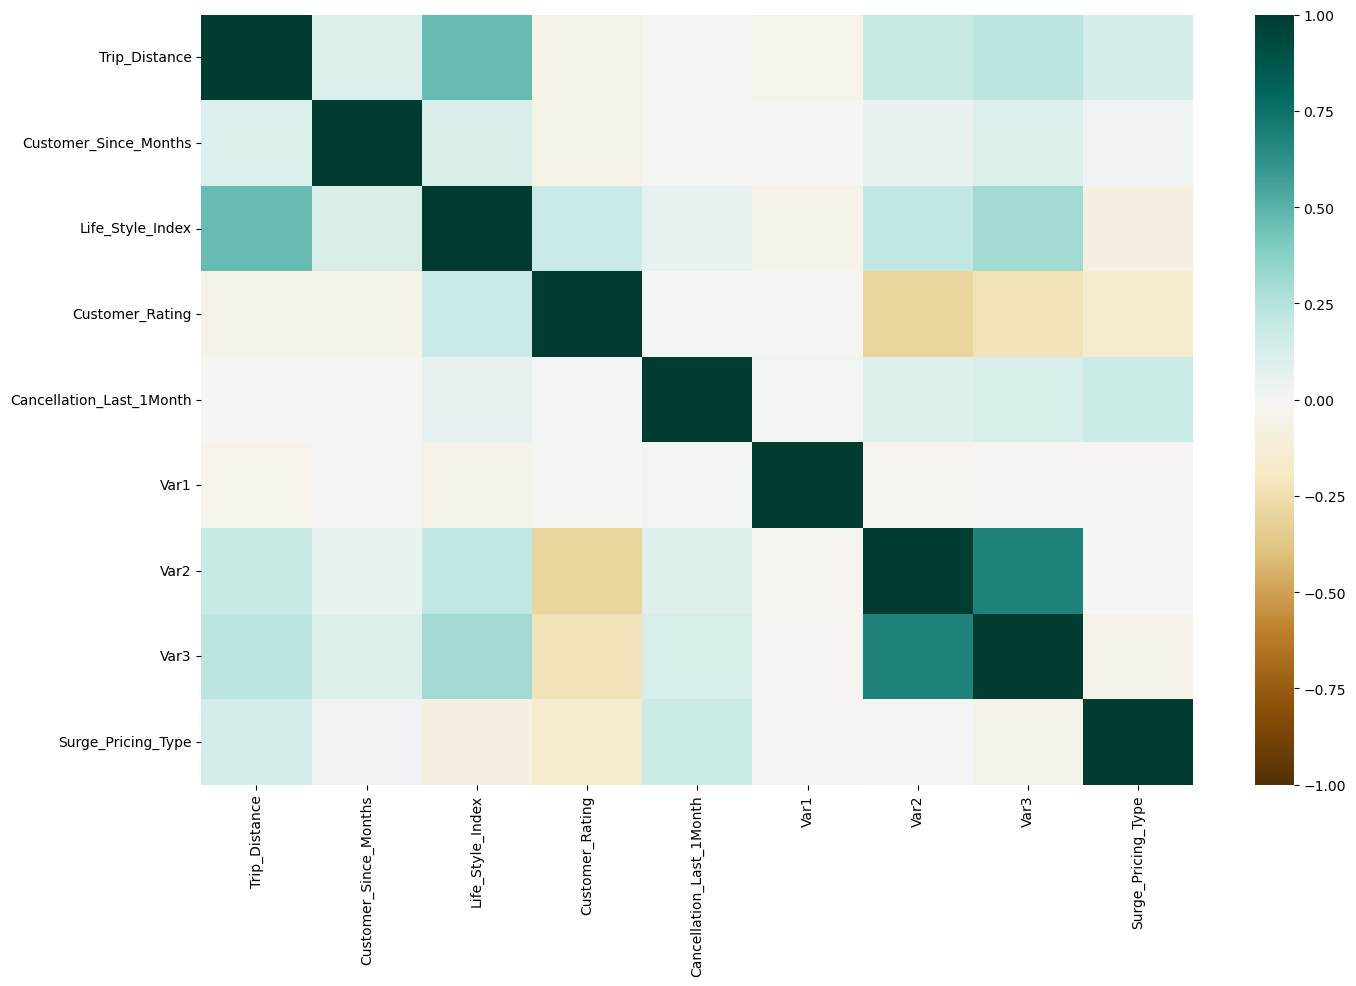

In [118]:
fig = plt.figure()
fig.set_size_inches(16,10)
sns.heatmap(df[numeric_columns].corr(),
            xticklabels = numeric_columns,
            yticklabels = numeric_columns,
            cmap = 'BrBG',
            vmin = -1,
            vmax = 1)
plt.show()

In [119]:
def get_redundant_pairs(data):
    pairs_to_drop = set()
    cols = data.columns
    for i in range(data.shape[1]):
        for j in range(0,i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(data, n=5):
    au_corr = data.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(data)
    au_corr = au_corr.drop(labels = labels_to_drop).sort_values(ascending = False)
    return au_corr[0:n].round(3)

print('Top abs correlations')
print(get_top_abs_correlations(df[numeric_columns], 5))

Top abs correlations
Var2              Var3                0.683
Trip_Distance     Life_Style_Index    0.468
Life_Style_Index  Var3                0.303
Customer_Rating   Var2                0.303
Trip_Distance     Var3                0.232
dtype: float64


### Преобразуем категориальные признаки

In [120]:
df.describe(include = object)

,Type_of_Cab,Confidence_Life_Style_Index,Destination_Type,Gender
count,131662,131662,131662,131662
unique,5,3,14,2
top,B,B,A,Male
freq,51346,60548,77597,93900


In [121]:
for col in categorical_columns:
    if col != 'Surge_Pricing_Type':
        one_hot = pd.get_dummies(df[col], prefix = col, drop_first = True)
        df = pd.concat((df.drop(col, axis = 1), one_hot), axis = 1)

In [122]:
df = df*1
df

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Surge_Pricing_Type,Type_of_Cab_B,...,Destination_Type_F,Destination_Type_G,Destination_Type_H,Destination_Type_I,Destination_Type_J,Destination_Type_K,Destination_Type_L,Destination_Type_M,Destination_Type_N,Gender_Male
Trip_ID,,,,,,,,,,,,,,,,,,,,,
T0005689460,6.77,1.0,2.42769,3.90500,0,40.0,46,60,2,1,...,0,0,0,0,0,0,0,0,0,0
T0005689461,29.47,10.0,2.78245,3.45000,0,38.0,56,78,2,1,...,0,0,0,0,0,0,0,0,0,1
T0005689464,41.58,10.0,2.79805,3.50125,2,61.0,56,77,2,1,...,0,0,0,0,0,0,0,0,0,1
T0005689465,61.56,10.0,2.79805,3.45375,0,61.0,52,74,3,0,...,0,0,0,0,0,0,0,0,0,1
T0005689467,54.95,10.0,3.03453,3.40250,4,51.0,49,102,2,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T0005908509,11.72,1.0,2.74229,3.28500,0,61.0,47,76,3,0,...,0,0,0,0,0,0,0,0,0,1
T0005908510,74.81,7.0,2.81059,0.44500,0,61.0,63,88,2,0,...,0,0,0,0,0,0,0,0,0,1
T0005908512,40.17,10.0,2.99565,3.33625,0,61.0,48,75,2,0,...,0,0,0,0,0,0,0,0,0,0


### Training

In [123]:
np.random.seed(2022)

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [124]:
X = df.drop('Surge_Pricing_Type', axis = 1)
y = df['Surge_Pricing_Type']

In [125]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=2022)

**Задание 1.** Обучите One-vs-Rest Logreg. Не забудьте в шаг добавить стандартизацию данных (через `StandardScaler`) Посчитайте precision, recall, f1-score и усредните по всем классам с помощью micro, macro и weighted avg. Здесь и далее округляйте до 3 знака после запятой.

Чтобы отдельно и долго не вычислять метрики, можно воспользоваться `classification_report` из `sklearn.metrics`!

In [126]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
### Your code is here
pipe = Pipeline([('scaler', StandardScaler()),
                ('one_vs_rest', OneVsRestClassifier(estimator = LogisticRegression()))])

pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('one_vs_rest',
                 OneVsRestClassifier(estimator=LogisticRegression()))])

In [127]:
from sklearn.metrics import precision_score, recall_score, f1_score
print('Macro average')
print(f'precision score is {precision_score(y_test, pipe.predict(X_test), 
                                           average = 'macro'):.3f}')
print(f'recall score is {recall_score(y_test, pipe.predict(X_test), 
                                           average = 'macro'):.3f}')
print(f'f1_score is {f1_score(y_test, pipe.predict(X_test), 
                                           average = 'macro'):.3f}')
print()

print('Micro average')
print(f'precision score is {precision_score(y_test, pipe.predict(X_test), 
                                           average = 'micro'):.3f}')
print(f'recall score is {recall_score(y_test, pipe.predict(X_test), 
                                           average = 'micro'):.3f}')
print(f'f1_score is {f1_score(y_test, pipe.predict(X_test), 
                                           average = 'micro'):.3f}')
print()

print('Weighted average')
print(f'precision score is {precision_score(y_test, pipe.predict(X_test), 
                                           average = 'weighted'):.3f}')
print(f'recall score is {recall_score(y_test, pipe.predict(X_test), 
                                           average = 'weighted'):.3f}')
print(f'f1_score is {f1_score(y_test, pipe.predict(X_test), 
                                           average = 'weighted'):.3f}')

Macro average
precision score is 0.700
recall score is 0.649
f1_score is 0.662

Micro average
precision score is 0.679
recall score is 0.679
f1_score is 0.679

Weighted average
precision score is 0.692
recall score is 0.679
f1_score is 0.673


In [128]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pipe.predict(X_test), digits = 3))

              precision    recall  f1-score   support

           1      0.723     0.542     0.619      5372
           2      0.636     0.834     0.722     11349
           3      0.741     0.571     0.645      9612

    accuracy                          0.679     26333
   macro avg      0.700     0.649     0.662     26333
weighted avg      0.692     0.679     0.673     26333



Подберите оптимальные гиперпараметры модели с помощью `GridSearchCV()` из предложенных. Для лучшего набора гиперпараметров посчитайте те же самые метрики. Валидировать параметры необходимо по `accuracy`. В этот раз проведем настояющую процедуру Кросс-Валидации! 

Для этого в метод `fit` передадим тренировочную часть наших данных, в параметр `cv` ничего не будем передавать (по дефолту 5-fold Кросс-Валидация будет проведена), а итоговые метрики замерим на тесте!

In [129]:
param_grid = {'one_vs_rest__estimator__penalty': ['l1', 'l2', 'elasticnet'],
              'one_vs_rest__estimator__C': [0.001, 0.01, 0.1, 1]}

In [130]:
from sklearn.model_selection import GridSearchCV
### Your code is here
search = GridSearchCV(pipe, param_grid)
search.fit(X_train, y_train)


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('one_vs_rest',
                                        OneVsRestClassifier(estimator=LogisticRegression()))]),
             param_grid={'one_vs_rest__estimator__C': [0.001, 0.01, 0.1, 1],
                         'one_vs_rest__estimator__penalty': ['l1', 'l2',
                                                             'elasticnet']})

In [131]:
print(f'CV score with best params is {search.best_score_:.3f}')
print(search.best_params_)

CV score with best params is 0.681
{'one_vs_rest__estimator__C': 0.001, 'one_vs_rest__estimator__penalty': 'l2'}


In [132]:
pipe.set_params(one_vs_rest__estimator__C = 0.001, one_vs_rest__estimator__penalty = 'l2')
pipe.fit(X_train, y_train)
print(classification_report(y_test, pipe.predict(X_test), digits = 3))

              precision    recall  f1-score   support

           1      0.742     0.534     0.621      5372
           2      0.635     0.839     0.723     11349
           3      0.742     0.576     0.649      9612

    accuracy                          0.681     26333
   macro avg      0.706     0.650     0.664     26333
weighted avg      0.696     0.681     0.675     26333



Изобразите три калибровочные кривые для Logistic Classifier: 0-vs-rest, 1-vs-rest, 2-vs-rest. Хорошо ли откалиброван обученный классификатор? 

Заметьте, что `predict_proba` возвращает список из вероятностей для всех наших классов!

In [133]:
### Your code is here
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output = False)
y_ohe = ohe.fit_transform(y_test.values.reshape(-1,1))

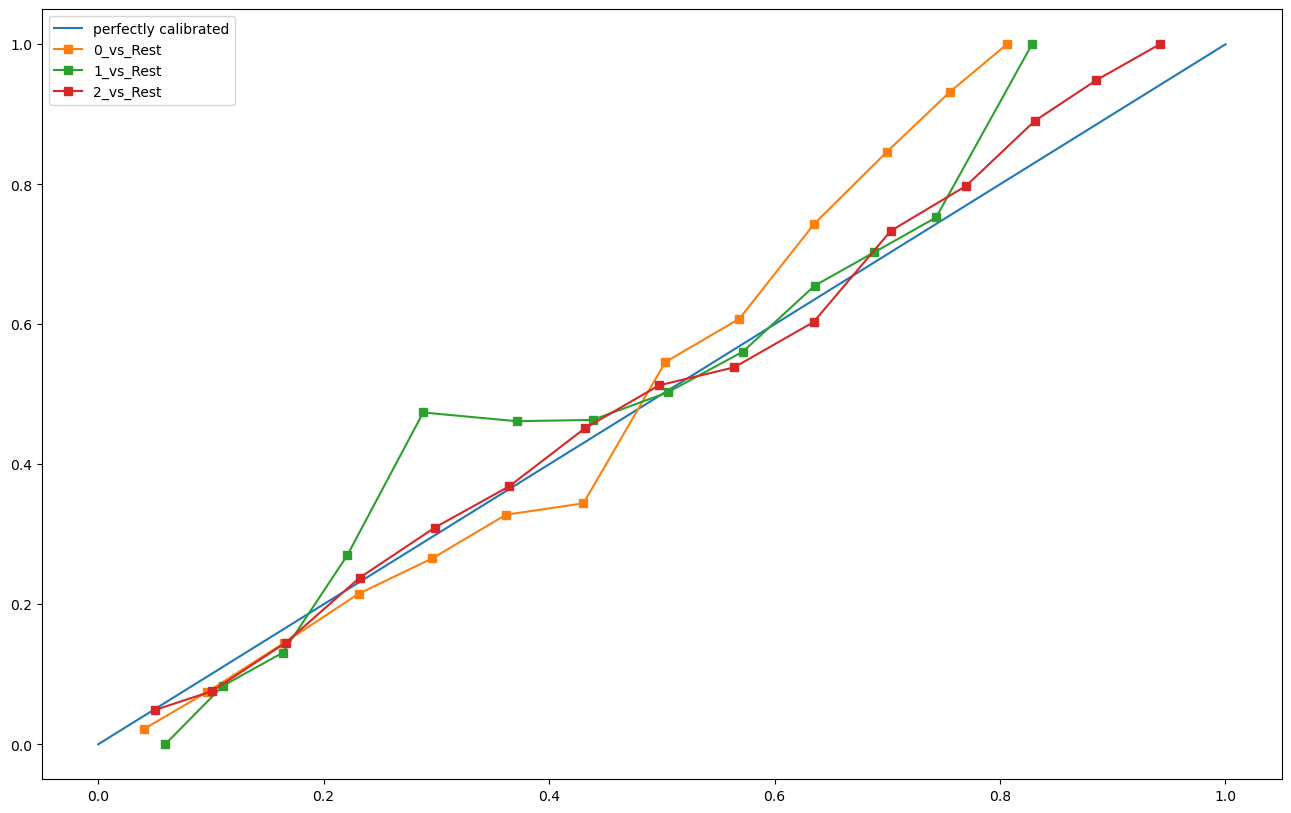

In [134]:
from sklearn.calibration import calibration_curve
fig = plt.figure()
fig.set_size_inches(16,10)
plt.plot([0,1],[0,1], label = 'perfectly calibrated')

for label in range(3):
    predicted_probs = pipe.predict_proba(X_test)[:, label]
    fraction_of_positives, mean_target_value = calibration_curve(y_ohe[:, label],
                                                                predicted_probs,
                                                                n_bins = 15)
    plt.plot(mean_target_value, fraction_of_positives, "s-", label = f"{label}_vs_Rest")
    
plt.legend()
plt.show()

**Задание 2.** Обучите логистическую регрессию с гиперпараметрами из первого задания на полиномиальных признаках до 4 степени. Сравните метрики с первым заданием.


Пример: Пусть у нас был единственный признак 

$$
d_j = [1, 2, 3, 4]
$$

Тогда полиномиальные признаки до 4 степени от такого будут иметь вид:

$$
d_j^1 = [1, 2, 3, 4]
$$

$$
d_j^2 = [1, 4, 9, 16]
$$

$$
d_j^3 = [1, 8, 27, 64]
$$

$$
d_j^4 = [1, 16, 81, 256]
$$

P.S. Бинарные колонки нет смысла возводить в какие-то степени, поэтому возьмем исключительно вещественные из базовых. 

Для этого можно воспользоваться классическим циклом (или уроком из занятия про `Sberbank Housing Market`). Положите модифицированный датасет в переменную `X_polinomial`!

P.S.S Зачастую еще, создаваю полиномиальные фичи, учитывают "пересечения" признаков, то есть, например, из векторов признаков $d_j, d_i$ генерируют не просто новые степени $d_j^2, d_i^2, d_j^3, d_i^3...$, а еще и признаки вида $d_j \cdot d_i, d_j^2 \cdot d_i, d_j \cdot d_i^2...$, но здесь ограничьтесь просто степенями!

In [135]:
### Создание полиномиальных признаков

X_polinomial = X.copy()
print(numeric_columns)
for col in numeric_columns.drop('Surge_Pricing_Type'):
    for i in [2,3,4]:
        new_col = (X_polinomial[col]**i).to_frame().rename({col:f"{col}_{i}"}, axis = 1)
        X_polinomial = pd.concat((X_polinomial, new_col), axis = 1)

X_polinomial

### Your code is here

Index(['Trip_Distance', 'Customer_Since_Months', 'Life_Style_Index',
       'Customer_Rating', 'Cancellation_Last_1Month', 'Var1', 'Var2', 'Var3',
       'Surge_Pricing_Type'],
      dtype='object')


,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Type_of_Cab_B,Type_of_Cab_C,...,Cancellation_Last_1Month_4,Var1_2,Var1_3,Var1_4,Var2_2,Var2_3,Var2_4,Var3_2,Var3_3,Var3_4
Trip_ID,,,,,,,,,,,,,,,,,,,,,
T0005689460,6.77,1.0,2.42769,3.90500,0,40.0,46,60,1,0,...,0,1600.0,64000.0,2560000.0,2116,97336,4477456,3600,216000,12960000
T0005689461,29.47,10.0,2.78245,3.45000,0,38.0,56,78,1,0,...,0,1444.0,54872.0,2085136.0,3136,175616,9834496,6084,474552,37015056
T0005689464,41.58,10.0,2.79805,3.50125,2,61.0,56,77,1,0,...,16,3721.0,226981.0,13845841.0,3136,175616,9834496,5929,456533,35153041
T0005689465,61.56,10.0,2.79805,3.45375,0,61.0,52,74,0,1,...,0,3721.0,226981.0,13845841.0,2704,140608,7311616,5476,405224,29986576
T0005689467,54.95,10.0,3.03453,3.40250,4,51.0,49,102,0,1,...,256,2601.0,132651.0,6765201.0,2401,117649,5764801,10404,1061208,108243216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T0005908509,11.72,1.0,2.74229,3.28500,0,61.0,47,76,0,0,...,0,3721.0,226981.0,13845841.0,2209,103823,4879681,5776,438976,33362176
T0005908510,74.81,7.0,2.81059,0.44500,0,61.0,63,88,0,1,...,0,3721.0,226981.0,13845841.0,3969,250047,15752961,7744,681472,59969536
T0005908512,40.17,10.0,2.99565,3.33625,0,61.0,48,75,0,1,...,0,3721.0,226981.0,13845841.0,2304,110592,5308416,5625,421875,31640625


In [136]:
X_pol_train, X_pol_test, y_train, y_test  = train_test_split(X_polinomial, y, 
                                                             test_size=0.2, 
                                                             shuffle=True, 
                                                             random_state=2022)

In [138]:
### Your code is here
pipe2 = Pipeline([('scaler', StandardScaler()),
                 ('one_vs_all', OneVsRestClassifier(estimator = LogisticRegression()))])
pipe2.set_params(one_vs_all__estimator__C = 0.001, one_vs_all__estimator__penalty = 'l2')
pipe2.fit(X_pol_train, y_train)
print(classification_report(y_test, pipe2.predict(X_pol_test), digits = 3))

              precision    recall  f1-score   support

           1      0.748     0.532     0.622      5372
           2      0.636     0.837     0.723     11349
           3      0.741     0.584     0.653      9612

    accuracy                          0.682     26333
   macro avg      0.708     0.651     0.666     26333
weighted avg      0.697     0.682     0.677     26333



По аналогии с первым заданием изобразите три калибровочные кривые. Стало ли лучше?

In [141]:
ohe = OneHotEncoder(sparse_output=False)
y_ohe = ohe.fit_transform(y_test.values.reshape(-1, 1))

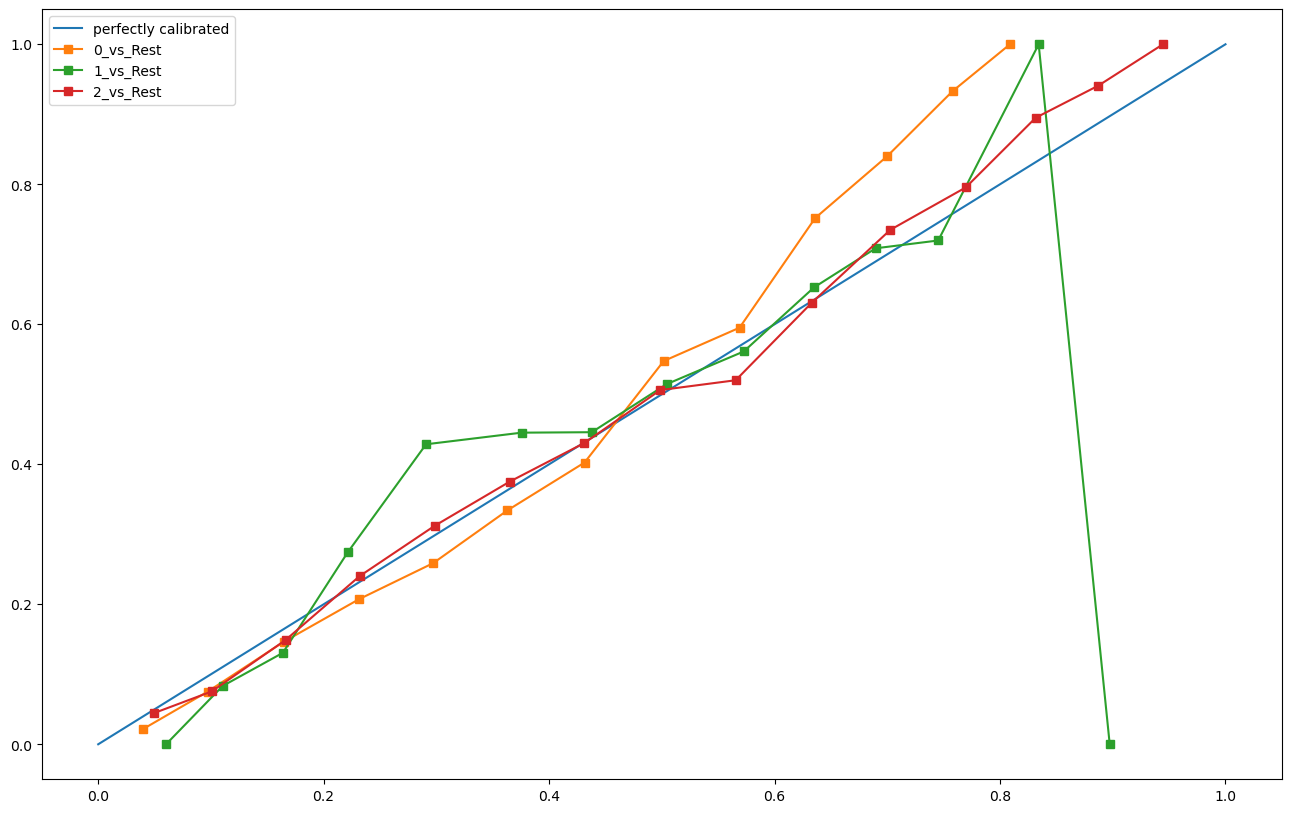

In [142]:
### Your code is here

from sklearn.calibration import calibration_curve
fig = plt.figure()
fig.set_size_inches(16,10)
plt.plot([0,1],[0,1], label = 'perfectly calibrated')

for label in range(3):
    predicted_probs = pipe2.predict_proba(X_pol_test)[:, label]
    fraction_of_positives, mean_target_value = calibration_curve(y_ohe[:, label],
                                                                predicted_probs,
                                                                n_bins = 15)
    plt.plot(mean_target_value, fraction_of_positives, "s-", label = f"{label}_vs_Rest")
    
plt.legend()
plt.show()

**Задание 3.** Обучите на датасете без полиномиальных признаков One-vs-One `SGDClassifier` из `sklearn.linear_model`, который использует стохастический градиентный спуск (узнаете о нем позже) и может обучать как `SVM`, так и, например, `LogReg`, если указать в качестве параметра `loss` либо `hinge`, либо `log` соответственно!

Посчитайте precision, recall, f1-score и усредните по всем классам с помощью micro, macro и weighted avg.

In [143]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=2022)

In [144]:
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsOneClassifier

### Your code is here
pipe_one_vs_one = Pipeline([('scaler', StandardScaler()),
                           ('one_vs_one', OneVsOneClassifier(estimator = SGDClassifier(loss = 'hinge')))])
pipe_one_vs_one.fit(X_train, y_train)
print(classification_report(y_test, pipe_one_vs_one.predict(X_test), digits = 3))

              precision    recall  f1-score   support

           1      0.748     0.521     0.614      5372
           2      0.626     0.870     0.728     11349
           3      0.756     0.536     0.627      9612

    accuracy                          0.677     26333
   macro avg      0.710     0.642     0.656     26333
weighted avg      0.698     0.677     0.668     26333



Подберите оптимальные гиперпараметры модели с помощью `GridSearchCV()`. При этом переберите всевозможные функции потерь. Таким образом, при `loss = 'hinge'`, мы обучим SVM, при `loss = 'log'` мы обучим логистическую регрессию и т.д.

Используйте прием с Кросс-Валидацией при подборе параметров, как ранее, а также замерьте метрики на тесте.

In [151]:
param_grid = {'one_vs_one__estimator__loss': ['hinge', 'log', 'modified_huber'],
              'one_vs_one__estimator__penalty': ['l1', 'l2'],
              'one_vs_one__estimator__alpha': [0.001, 0.01, 0.1]}

In [152]:
### Your code is here
search_one_vs_one = GridSearchCV(pipe_one_vs_one, param_grid)
search_one_vs_one.fit(X_train, y_train)
print(f'Best CV Score is {search_one_vs_one.best_score_:.3f}')
print(f'best params are {search_one_vs_one.best_params_}')

Best CV Score is 0.681
best params are {'one_vs_one__estimator__alpha': 0.1, 'one_vs_one__estimator__loss': 'hinge', 'one_vs_one__estimator__penalty': 'l2'}


In [154]:
pipe_one_vs_one.set_params(one_vs_one__estimator__alpha = 0.1, one_vs_one__estimator__loss = 'hinge', one_vs_one__estimator__penalty = 'l2')
pipe_one_vs_one.fit(X_train, y_train)
print(classification_report(y_test, search_one_vs_one.predict(X_test), digits = 3))

              precision    recall  f1-score   support

           1      0.756     0.517     0.615      5372
           2      0.625     0.876     0.730     11349
           3      0.762     0.535     0.628      9612

    accuracy                          0.678     26333
   macro avg      0.714     0.643     0.658     26333
weighted avg      0.702     0.678     0.669     26333



Можно ли однозначно сказать, какой подход оказался лучше: One-vs-Rest или One-vs-One?